# Regression to Predict the runs scored given the type of bowlers expected to bowl and the state of the match

Here, we will consider all the data available as we trying to get a relation between the strike rate, and deliveries per wicket vs each type of bowler vs the expeted runs scored 

Input --> Batter,  Team , Ball number, Innings, Non- striker  
Ouput --> Runs

In [13]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../../Data/selected_data/processed_data_NRR_with_venues.csv')

# merging medium bowlers to fast
data.loc[data['bowler_type'] == 'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
data.loc[data['bowler_type'] == 'Right arm Medium', 'bowler_type'] = 'Right arm Fast'
data['date'] = data['match_id'].apply(lambda x: x[-10: ])
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215252 entries, 0 to 215251
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           215252 non-null  int64         
 1   batter               215252 non-null  object        
 2   bowler               215252 non-null  object        
 3   non_striker          215252 non-null  object        
 4   runs_by_bat          215252 non-null  int64         
 5   extra_runs           215252 non-null  int64         
 6   total_runs_delivery  215252 non-null  int64         
 7   current_team_total   215252 non-null  int64         
 8   runs_remain          215252 non-null  float64       
 9   batter_runs          215252 non-null  int64         
 10  balls_faced          215252 non-null  int64         
 11  wickets_fallen       215252 non-null  int64         
 12  extra_type           215252 non-null  object        
 13  delivery      

In [2]:
data.iloc[:, 10:].head(20)

,wickets_fallen,extra_type,delivery,over,wicket_type,player_out,toss_decision,toss_winner,innings,venue,...,batting_team,bowling_team,won,final_team_total,batter_type,non_striker_type,bowler_type,replacements,net_run_rate,date
0,0,-,1.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
1,0,-,2.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
2,0,-,3.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
3,0,-,4.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
4,0,-,5.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
5,0,-,6.0,0,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
6,0,-,1.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
7,0,-,2.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
8,0,-,3.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17
9,0,-,4.0,1,0,Not Out,field,Sri Lanka,1,Melbourne Cricket Ground,...,Australia,Sri Lanka,0.0,168,Right hand Bat,Right hand Bat,Right arm Fast,No Replacement,-0.2,2017-02-17


In [50]:
def getPlayerScores(player_name: str, innings: list[int] = [1, 2]) -> pd.DataFrame:
    # Get the data for BKG Mendis if batter is BKG Mendis or non-striker is BKG Mendis
	player_data = data.loc[
		((data['batter'] == player_name) | (data['non_striker'] == player_name)) & (
		    data['innings'].isin(innings))
	]

	player_data.head()

	# group data by match_id
	gp = player_data.groupby('match_id')
	cols = ['date', 'batter', 'non_striker', 'batter_runs', 'balls_faced', 'wicket_type', 'won', 'innings', 'over',
	    'delivery', 'wickets_fallen', 'bowling_team', 'batting_team', 'venue', 'toss_winner', 'runs_remain']
	player_scores = gp.last().loc[:, cols]

	# get the first ball he faced or at non-striker
	first_ball = gp.first().loc[:, ['over', 'delivery',
	                      'wickets_fallen', 'current_team_total']]
	first_ball['first_ball'] = (
	    first_ball['over'] * 6 + first_ball['delivery']).astype(int)

	player_scores['first_ball'] = first_ball['first_ball']
	player_scores['wickets_fallen'] = first_ball['wickets_fallen']
	player_scores['current_team_total'] = first_ball['current_team_total']
	player_scores['is_powerplay'] = first_ball['first_ball'] <= 30

    # convert toss win to boolean
	player_scores['toss_winner'] = (
	    player_scores['toss_winner'] == player_scores['batting_team']).astype(int);

    # when BKG Mendis is the non-striker when the last ball was bowled
	# The batter_runs and balls_faced are not his, but the on_strike batter's
	# So, we need to get the last ball he faced
	# he might not even have faced a ball

	# get the last ball he faced

	matches_non_striker = player_scores[player_scores['non_striker']
	    == player_name].index

	# Sometimes the player might not even have faced a single ball
	# Eg: Afghanistan_Sri Lanka_2022-11-01 MD Shanaka not out on the non strikers end

	player_scores.loc[matches_non_striker, [
	    'batter_runs', 'balls_faced']] = [0, 0]

	# get the last batter == player_name row from gp data
	gp = player_data[(player_data['batter'] == player_name) & (
	    player_data['match_id'].isin(matches_non_striker))].groupby(['match_id'])
	last_batter_scores = gp.last()[['batter_runs', 'balls_faced']]

	# update the rows with non_striker with correct values
	player_scores.update(last_batter_scores)

	# adding new features
	# strike rate
	player_scores['strike_rate'] = round(
	    player_scores['batter_runs'] / player_scores['balls_faced'] * 100, 2)
	player_scores['out'] = player_scores['wicket_type'] != '0'
	player_scores['last_ball'] = (
	    player_scores['over'] * 6 + player_scores['delivery']).astype(int)

	# drop over and delivery
	player_scores.drop(['over', 'delivery'], inplace=True, axis=1)

	# concatenating the remaining bowler types number to the dataset
	matches = data[data['match_id'].isin(player_scores.index)]
	# matches = matches[matches['batting_team'] == 'Sri Lanka']
	cols = ['match_id', 'batter', 'non_striker', 'bowler_type', 'batter_runs',
	    'balls_faced', 'wicket_type', 'won', 'innings', 'over', 'delivery', 'wickets_fallen']
	matches = matches[cols]
	matches['ball_number'] = (matches['over'] * 6 +
	                          matches['delivery']).astype(int)
	matches.drop(['over', 'delivery'], inplace=True, axis=1)

	def filter_by_player_and_ball_number(group):
		player_data = group[group['batter'] == player_name]

		if player_data.empty:
			return player_data.drop('match_id', axis=1)

		first_ball_number = player_data['ball_number'].iloc[0]

		# return player_data[player_data['ball_number'] > first_ball_number].drop('match_id', axis=1) # This is for number of balls faced

		# fixed error should be greater or equal
		remaining = group[group['ball_number'] >= first_ball_number].drop(
		    'match_id', axis=1)  # return the remianing number of deliveries for each type
		return remaining

	gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
	remaining_ball_types = gp.groupby(
	    'match_id')['bowler_type'].value_counts().unstack(fill_value=0)
	remaining_ball_types = remaining_ball_types.reset_index()

	player_scores = player_scores.merge(
	    remaining_ball_types, how='left', on='match_id')

	player_scores.fillna(0, inplace=True)
	
    
    # if batsman ended as non_striker, make him the batter and drop the nonstriker column
	player_scores['batter'] = player_name
	player_scores.drop('non_striker', inplace=True, axis = 1)



	# Sort according to date
	player_scores.sort_values(by='date', inplace=True)

	def calculate_recent_form(row, window=30):
		"""
		Calculates the average runs scored by the player in the last 'window' days (excluding the current date).
		"""
		date = row['date']
		df = player_scores.copy()
		df = df[df['date'] < date]
		df = df[df['date'] >= (date - pd.Timedelta(days=window))]
		average_runs = df['batter_runs'].mean() if len(df) > 0 else 0
		return average_runs	

	player_scores['recent_form'] = player_scores.apply(calculate_recent_form, axis=1)
	
	# reindex
	player_scores.reset_index(drop=True, inplace=True)

	return player_scores




In [51]:
# selected_batters = ["PWH de Silva",'KIC Asalanka','BKG Mendis',"P Nissanka",'PHKD Mendis','S Samarawickrama','AD Mathews','MD Shanaka','DM de Silva','M Theekshana','PVD Chameera','N Thushara','M Pathirana','D Madushanka']

merged_df = pd.DataFrame()

for player in data['batter'].unique():
    print("Analyzing Player", player)
    
    player_scores = getPlayerScores(player)
    merged_df = pd.concat([merged_df, player_scores])

merged_df.to_csv('merged_df_checkpoint.csv')

Analyzing Player AJ Finch


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player M Klinger
Analyzing Player TM Head
Analyzing Player MC Henriques


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AJ Turner
Analyzing Player JP Faulkner
Analyzing Player N Dickwella


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player WU Tharanga
Analyzing Player EMDY Munaweera


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DAS Gunaratne
Analyzing Player TAM Siriwardana


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CK Kapugedera
Analyzing Player S Prasanna


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player BR Dunk
Analyzing Player TD Paine
Analyzing Player PJ Cummins


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AJ Tye
Analyzing Player JA Richardson
Analyzing Player BKG Mendis


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KMDN Kulasekara
Analyzing Player SL Malinga


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MD Shanaka


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JRMVB Sanjaya
Analyzing Player KL Rahul


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AT Rayudu
Analyzing Player Mandeep Singh
Analyzing Player MK Pandey


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KM Jadhav
Analyzing Player MS Dhoni


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AR Patel
Analyzing Player R Dhawan
Analyzing Player CJ Chibhabha


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player H Masakadza
Analyzing Player R Mutumbami


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Sikandar Raza
Analyzing Player MN Waller


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CT Mutombodzi
Analyzing Player E Chigumbura


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AG Cremer
Analyzing Player N Madziva
Analyzing Player PJ Moor


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DT Tiripano
Analyzing Player T Muzarabani
Analyzing Player DS Kulkarni
Analyzing Player V Sibanda


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player T Maruma
Analyzing Player Tamim Iqbal


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Imrul Kayes
Analyzing Player Sabbir Rahman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shakib Al Hasan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Soumya Sarkar


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mahmudullah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mosaddek Hossain
Analyzing Player Mashrafe Mortaza


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Nurul Hasan
Analyzing Player Rubel Hossain


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NT Broom
Analyzing Player KS Williamson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player C Munro


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CJ Anderson
Analyzing Player TC Bruce


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player C de Grandhomme
Analyzing Player Mustafizur Rahman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player L Ronchi
Analyzing Player JDS Neesham


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MJ Santner
Analyzing Player GD Phillips


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BM Wheeler
Analyzing Player TG Southee


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TA Boult
Analyzing Player HM Amla


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Q de Kock


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player F du Plessis
Analyzing Player AB de Villiers


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JP Duminy


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player F Behardien
Analyzing Player CH Morris


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WD Parnell
Analyzing Player JJ Roy


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AD Hales


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JM Bairstow


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JT Smuts
Analyzing Player RR Hendricks


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DA Miller


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SW Billings
Analyzing Player LS Livingstone


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JC Buttler


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player EJG Morgan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LA Dawson
Analyzing Player M Mosehle
Analyzing Player AL Phehlukwayo


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player M Morkel
Analyzing Player D Paterson
Analyzing Player DJ Malan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LE Plunkett
Analyzing Player DJ Willey
Analyzing Player TK Curran


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JE Root
Analyzing Player AU Rashid


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CJ Jordan
Analyzing Player CH Gayle


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player E Lewis
Analyzing Player MN Samuels


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CAK Walton
Analyzing Player KA Pollard


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player R Powell


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CR Brathwaite
Analyzing Player SP Narine


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AR Nurse
Analyzing Player JE Taylor


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KOK Williams
Analyzing Player BA Stokes


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player V Kohli


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SK Raina


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Yuvraj Singh


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player HH Pandya


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Parvez Rasool
Analyzing Player MM Ali


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player TS Mills
Analyzing Player RR Pant


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RG Sharma


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AM Rahane
Analyzing Player J Charles


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AD Russell


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DJ Bravo


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LMP Simmons


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Sharjeel Khan
Analyzing Player Khalid Latif


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Babar Azam


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player ADS Fletcher


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player N Pooran


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Badree
Analyzing Player Shoaib Malik


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Sarfraz Ahmed


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Umar Akmal


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DA Warner


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DJM Short
Analyzing Player CA Lynn


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GJ Maxwell


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MJ Guptill


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player LRPL Taylor


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TA Blundell
Analyzing Player IS Sodhi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MP Stoinis


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AT Carey
Analyzing Player MA Wood


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JM Vince
Analyzing Player MS Chapman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TL Seifert


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AC Agar
Analyzing Player Mushfiqur Rahim


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Saifuddin
Analyzing Player Mehedi Hasan Miraz


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Taskin Ahmed
Analyzing Player Shafiul Islam


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Liton Das


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Kamran Akmal
Analyzing Player Ahmed Shehzad


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Hafeez


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JO Holder
Analyzing Player Fakhar Zaman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Imad Wasim
Analyzing Player Sohail Tanvir


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shadab Khan
Analyzing Player Wahab Riaz


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Hasan Ali
Analyzing Player MDKJ Perera


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player NLTC Perera


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JN Mohammed
Analyzing Player S Dhawan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KD Karthik


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RA Jadeja


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player R Ashwin
Analyzing Player AD Mathews


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SMA Priyanjan
Analyzing Player I Udana
Analyzing Player AK Kitchen


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DAJ Bracewell
Analyzing Player SD Hope


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SO Hetmyer
Analyzing Player RR Emrit
Analyzing Player Umar Amin
Analyzing Player Mohammad Nawaz (3)


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Haris Sohail
Analyzing Player Faheem Ashraf


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Amir
Analyzing Player SHA Rance
Analyzing Player Aamer Yamin


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DT Christian
Analyzing Player NM Coulter-Nile
Analyzing Player A Zampa


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player B Kumar
Analyzing Player Kuldeep Yadav
Analyzing Player JJ Bumrah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player YS Chahal
Analyzing Player KW Richardson
Analyzing Player MJ Swepson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player B Stanlake
Analyzing Player TWM Latham
Analyzing Player HM Nicholls


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SS Iyer
Analyzing Player MD Gunathilaka


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player S Samarawickrama
Analyzing Player ML Udawatte
Analyzing Player SS Pathirana


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player PC de Silva
Analyzing Player H Klaasen


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CJ Dala
Analyzing Player T Shamsi
Analyzing Player C Jonker


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player A Dananjaya
Analyzing Player PVD Chameera
Analyzing Player MVT Fernando
Analyzing Player N Pradeep
Analyzing Player Zakir Hasan
Analyzing Player Afif Hossain


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Ariful Haque
Analyzing Player Mohammad Mithun


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mahedi Hasan
Analyzing Player Abu Jayed


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Nazmul Islam
Analyzing Player LD Chandimal


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BMAJ Mendis
Analyzing Player RAS Lakmal
Analyzing Player V Shankar


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mohammad Shahzad
Analyzing Player Karim Sadiq
Analyzing Player Asghar Stanikzai


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mohammad Nabi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Sharafuddin Ashraf
Analyzing Player Najibullah Zadran


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Shafiqullah
Analyzing Player SF Mire
Analyzing Player BRM Taylor


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RP Burl
Analyzing Player KM Jarvis


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TL Chatara
Analyzing Player B Muzarabani
Analyzing Player Gulbadin Naib


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Rashid Khan
Analyzing Player Aftab Alam


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Hussain Talat
Analyzing Player Asif Ali


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player D Ramdin


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KMA Paul
Analyzing Player OF Smith


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AM McCarthy
Analyzing Player JL Denly
Analyzing Player DM de Silva


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player PHKD Mendis
Analyzing Player MA Aponso
Analyzing Player PADLR Sandakan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player PR Stirling
Analyzing Player JNK Shannon
Analyzing Player A Balbirnie


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Simi Singh
Analyzing Player GC Wilson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KJ O'Brien
Analyzing Player SW Poynter


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SR Thompson
Analyzing Player GH Dockrell


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WB Rankin
Analyzing Player PKD Chase
Analyzing Player WTS Porterfield


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player K Rabada
Analyzing Player L Ngidi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player TK Musakanda
Analyzing Player TS Chisoro
Analyzing Player J Nyumbu
Analyzing Player CB Mpofu
Analyzing Player C Zhuwao


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player NJ Maddinson
Analyzing Player B Mavuta
Analyzing Player WP Masakadza


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JD Wildermuth
Analyzing Player Sahibzada Farhan
Analyzing Player GL Cloete


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player HE van der Dussen


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SC Williams
Analyzing Player Mohammad Rizwan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JN Malan
Analyzing Player Shaheen Shah Afridi
Analyzing Player BE Hendricks


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player L Sipamla
Analyzing Player DW Steyn
Analyzing Player Imran Tahir


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player WIA Fernando
Analyzing Player AK Perera


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player AK Markram
Analyzing Player D Pretorius


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BR McDermott
Analyzing Player KH Pandya
Analyzing Player Usman Ghani


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Samiullah Shenwari
Analyzing Player Karim Janat
Analyzing Player Abul Hasan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Abu Hider
Analyzing Player Hazratullah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player J Little
Analyzing Player TE Kane
Analyzing Player BM Duckett


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Imam-ul-Haq
Analyzing Player DM Bravo
Analyzing Player FA Allen


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SS Cottrell
Analyzing Player O Thomas
Analyzing Player SE Rutherford


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player KK Ahmed
Analyzing Player DJ Mitchell
Analyzing Player SC Kuggeleijn
Analyzing Player CAK Rajitha
Analyzing Player CBRLS Kumara


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MR Marsh
Analyzing Player NM Lyon


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player LH Ferguson
Analyzing Player K Pierre
Analyzing Player D Bishoo


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player OC McCoy
Analyzing Player JD Campbell
Analyzing Player SC Getkate


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player L Tucker
Analyzing Player Najeeb Tarakai
Analyzing Player PSP Handscomb


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player UT Yadav
Analyzing Player CR Ervine
Analyzing Player GJ Thompson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MR Adair
Analyzing Player GJ Delany


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player PBB Rajapaksa
Analyzing Player BOP Fernando


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player PWH de Silva
Analyzing Player SPD Smith
Analyzing Player GSNFG Jayasuriya


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Iftikhar Ahmed
Analyzing Player Khushdil Shah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Hasnain
Analyzing Player T Bavuma


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BC Fortuin
Analyzing Player MS Wade


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MA Starc
Analyzing Player PJ van Biljon
Analyzing Player A Nortje


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Washington Sundar
Analyzing Player Navdeep Saini
Analyzing Player Mohammad Naim


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player S Dube
Analyzing Player Aminul Islam
Analyzing Player BA King


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DL Chahar
Analyzing Player HR Walsh
Analyzing Player SM Curran


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player L Gregory
Analyzing Player S Mahmood
Analyzing Player PR Brown


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player T Banton
Analyzing Player BM Tickner
Analyzing Player SV Samson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SN Thakur
Analyzing Player HK Bennett
Analyzing Player HD Rutherford


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player TD Astle
Analyzing Player LD Madushanka
Analyzing Player Rahmanullah Gurbaz


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Ibrahim Zadran
Analyzing Player Fareed Ahmad


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Naveen-ul-Haq
Analyzing Player Mujeeb Ur Rahman
Analyzing Player RW Chakabva


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Taijul Islam
Analyzing Player Nazmul Hossain Shanto
Analyzing Player A Ndlovu


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Fazal Niazai
Analyzing Player Haider Ali
Analyzing Player M Bhanuka


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player HT Tector
Analyzing Player BJ McCarthy


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CA Young
Analyzing Player Ahsan Ali
Analyzing Player TS Kamunhukamwe


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player W Madhevere
Analyzing Player CT Mumba


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SA Abbott
Analyzing Player DR Sams
Analyzing Player Abdullah Shafique


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player M Shumba
Analyzing Player M Faraz Akram
Analyzing Player DP Conway


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KR Mayers
Analyzing Player Haris Rauf


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JR Philippe
Analyzing Player KA Jamieson
Analyzing Player Shoriful Islam


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Nasum Ahmed
Analyzing Player FH Allen


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WA Young
Analyzing Player GF Linde
Analyzing Player MW Parkinson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Sohaib Maqsood
Analyzing Player Azam Khan
Analyzing Player GJ Snyman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Usman Qadir
Analyzing Player Ishan Kishan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JC Archer
Analyzing Player SA Yadav


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player B Fernando
Analyzing Player WJ Lubbe
Analyzing Player SSB Magala
Analyzing Player PWA Mulder


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player LB Williams
Analyzing Player B White
Analyzing Player P Nissanka


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player KNA Bandara
Analyzing Player K Sinclair
Analyzing Player FH Edwards


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player R Shepherd
Analyzing Player AJ Hosein


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player HC Brook
Analyzing Player PD Salt


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player GHS Garton
Analyzing Player RJW Topley


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Danish Aziz
Analyzing Player T Marumani
Analyzing Player LM Jongwe


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Arshad Iqbal
Analyzing Player R Ngarava
Analyzing Player PP Shaw


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player KIC Asalanka
Analyzing Player C Karunaratne


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player RD Gaikwad
Analyzing Player D Padikkal
Analyzing Player N Rana


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player RTM Mendis
Analyzing Player RD Chahar
Analyzing Player CV Varun
Analyzing Player C Sakariya


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JR Hazlewood
Analyzing Player JP Behrendorff
Analyzing Player Mohammad Wasim


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JP Inglis
Analyzing Player M Theekshana


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JDF Vandersay
Analyzing Player K Mishara
Analyzing Player J Liyanage


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player D Myers
Analyzing Player Shamim Hossain
Analyzing Player NT Ellis


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player P Jayawickrama
Analyzing Player R Ravindra
Analyzing Player CE McConchie


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AY Patel
Analyzing Player JA Duffy
Analyzing Player C Campher


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player NA Rock
Analyzing Player W McClintock
Analyzing Player AR McBrine
Analyzing Player KA Maharaj


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player R Rampaul
Analyzing Player RL Chase
Analyzing Player CR Woakes


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DJ Hooda
Analyzing Player HV Patel
Analyzing Player Arshdeep Singh
Analyzing Player RJ Gleeson
Analyzing Player Avesh Khan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Ravi Bishnoi
Analyzing Player RR Rossouw


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player T Stubbs
Analyzing Player Saif Hassan
Analyzing Player Mohammad Nawaz


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player VR Iyer
Analyzing Player AF Milne


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DC Drakes
Analyzing Player M Jansen
Analyzing Player DC Thomas
Analyzing Player SSJ Brooks


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player M Labuschagne
Analyzing Player C Green
Analyzing Player BJ Dwarshuis


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player T Munyonga
Analyzing Player TH David
Analyzing Player Azmatullah Omarzai


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Fazalhaq Farooqi
Analyzing Player Shan Masood
Analyzing Player F Hand


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Hasan Mahmud
Analyzing Player B Evans
Analyzing Player Yasir Ali Chowdhury


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mohammed Shami
Analyzing Player Mohammad Haris
Analyzing Player Naseem Shah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Darwish Rasooli
Analyzing Player Qais Ahmad
Analyzing Player Munim Shahriar


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player D Cleaver
Analyzing Player MG Bracewell
Analyzing Player Hashmatullah Shahidi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player GI Hume
Analyzing Player N Thushara
Analyzing Player I Kaia
Analyzing Player Ihsanullah
Analyzing Player Afsar Zazai
Analyzing Player Noor Ahmad


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Nijat Masood
Analyzing Player C Madande
Analyzing Player Anamul Haque


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player RA Reifer
Analyzing Player AS Joseph
Analyzing Player Y Cariah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CJ Bowes
Analyzing Player HB Shipley
Analyzing Player PM Liyanagamage
Analyzing Player D Madushanka


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Parvez Hossain Emon
Analyzing Player VM Nyauchi
Analyzing Player WG Jacks
Analyzing Player OP Stone


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Aamer Jamal
Analyzing Player M Pathirana
Analyzing Player Shahnawaz Dhani
Analyzing Player AM Fernando


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mohammed Siraj
Analyzing Player L Wood
Analyzing Player AAP Atkinson
Analyzing Player Rehan Ahmed


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player BA Carse
Analyzing Player MJ Henry
Analyzing Player BG Lister
Analyzing Player Saim Ayub


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Zaman Khan
Analyzing Player GR Adair
Analyzing Player ST Doheny


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player GS Ballance
Analyzing Player Shubman Gill
Analyzing Player RA Tripathi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Shivam Mavi
Analyzing Player Umran Malik
Analyzing Player Rony Talukdar
Analyzing Player Towhid Hridoy


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Rishad Hossain
Analyzing Player Tayyab Tahir
Analyzing Player Sediqullah Atal
Analyzing Player MW Short


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AM Hardie
Analyzing Player D Brevis
Analyzing Player G Coetzee
Analyzing Player MP Breetzke


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player D Ferreira
Analyzing Player MW Forde
Analyzing Player G Motie
Analyzing Player Tilak Varma


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mukesh Kumar
Analyzing Player YBK Jaiswal
Analyzing Player RK Singh


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JM Sharma
Analyzing Player N Burger
Analyzing Player BV Sears


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Tanvir Islam
Analyzing Player Usama Mir
Analyzing Player Abbas Afridi
Analyzing Player Haseebullah Khan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JA Clarkson
Analyzing Player T Sangha
Analyzing Player CJ Green
Analyzing Player Rahmat Shah


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Noor Ali Zadran
Analyzing Player Shahidullah
Analyzing Player Zahir Khan
Analyzing Player S Daniel


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player L Croospulle
Analyzing Player MNK Fernando
Analyzing Player SSD Arachchige
Analyzing Player LU Igalagamage


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player RS Fernando
Analyzing Player SMLD Samarakoon
Analyzing Player V Viyaskanth
Analyzing Player N Vimukthi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mahmudul Hasan Joy
Analyzing Player Shahadat Hossain
Analyzing Player Jaker Ali


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mrittunjoy Chowdhury
Analyzing Player Rakibul Hasan
Analyzing Player R Mondol
Analyzing Player Omair Yousuf


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mirza Baig
Analyzing Player Rohail Nazir
Analyzing Player Qasim Akram
Analyzing Player Arafat Minhas


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Sufiyan Muqeem
Analyzing Player BJ Bennett
Analyzing Player T Gwandu
Analyzing Player Mohammad Ishaq


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Ijaz Ahmad Ahmadzai
Analyzing Player Nangeyalia Kharote
Analyzing Player AC Gilchrist
Analyzing Player ML Hayden


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player A Symonds
Analyzing Player MJ Clarke


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MEK Hussey
Analyzing Player RT Ponting


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DR Martyn
Analyzing Player B Lee
Analyzing Player JN Gillespie


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MS Kasprowicz
Analyzing Player GD McGrath
Analyzing Player ME Trescothick
Analyzing Player GO Jones


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player A Flintoff
Analyzing Player KP Pietersen


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MP Vaughan
Analyzing Player PD Collingwood
Analyzing Player AJ Strauss


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player VS Solanki
Analyzing Player SM Katich
Analyzing Player BB McCullum


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SP Fleming
Analyzing Player MS Sinclair
Analyzing Player SB Styris


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CD McMillan
Analyzing Player CL Cairns
Analyzing Player HJH Marshall


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AR Adams
Analyzing Player JW Wilson
Analyzing Player DR Tuffey
Analyzing Player KD Mills


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player NJ Astle
Analyzing Player JDP Oram
Analyzing Player GC Smith


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player JH Kallis
Analyzing Player HH Gibbs


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JM Kemp
Analyzing Player MV Boucher
Analyzing Player SM Pollock


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AG Prince
Analyzing Player JA Morkel
Analyzing Player CK Langeveldt


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player M Ntini
Analyzing Player A Nel
Analyzing Player IR Bell


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JWM Dalrymple
Analyzing Player MH Yardy
Analyzing Player CMW Read


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SI Mahmood
Analyzing Player Younis Khan
Analyzing Player Shahid Afridi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Yousuf
Analyzing Player Inzamam-ul-Haq
Analyzing Player Abdul Razzaq


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player TT Bresnan
Analyzing Player ST Jayasuriya


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DPMD Jayawardene
Analyzing Player TM Dilshan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player KC Sangakkara
Analyzing Player RP Arnold


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MF Maharoof
Analyzing Player CRD Fernando
Analyzing Player JR Hopes


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player HH Dippenaar
Analyzing Player AJ Hall
Analyzing Player JA Rudolph
Analyzing Player J Botha


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player GJP Kruger
Analyzing Player M Zondeki
Analyzing Player L Vincent
Analyzing Player PG Fulton


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JEC Franklin
Analyzing Player SE Bond


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player D Ganga
Analyzing Player RS Morton
Analyzing Player DR Smith


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player WW Hinds
Analyzing Player S Chanderpaul
Analyzing Player SR Watson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player GB Hogg
Analyzing Player NW Bracken
Analyzing Player LE Bosman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JJ van der Wath
Analyzing Player CL White


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player EC Joyce
Analyzing Player PA Nixon
Analyzing Player J Lewis
Analyzing Player MS Panesar


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JM Anderson
Analyzing Player JAH Marshall
Analyzing Player PD McGlashan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MR Gillespie
Analyzing Player MS Atapattu
Analyzing Player LPC Silva


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player HMCM Bandara
Analyzing Player V Sehwag
Analyzing Player SR Tendulkar
Analyzing Player D Mongia
Analyzing Player RJ Peterson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player R Telemachus
Analyzing Player T Henderson
Analyzing Player AN Cook
Analyzing Player MJ Prior


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player IJL Trott
Analyzing Player OA Shah
Analyzing Player AD Mascarenhas


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SCJ Broad
Analyzing Player DS Smith
Analyzing Player DJG Sammy


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player ACL Richards
Analyzing Player RR Sarwan
Analyzing Player BJ Hodge


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player BJ Haddin
Analyzing Player MG Johnson


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player T Taibu
Analyzing Player S Matsikenyeri
Analyzing Player Nazimuddin


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Aftab Ahmed
Analyzing Player Mohammad Ashraful
Analyzing Player Alok Kapali


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DBL Powell
Analyzing Player DL Maddy
Analyzing Player LJ Wright


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player CP Schofield
Analyzing Player P Utseya
Analyzing Player RJ Kirtley


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player G Gambhir
Analyzing Player RV Uthappa


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player IK Pathan
Analyzing Player Harbhajan Singh
Analyzing Player AB Agarkar


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player S Sreesanth
Analyzing Player Salman Butt
Analyzing Player Imran Nazir


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Misbah-ul-Haq
Analyzing Player Yasir Arafat


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DL Vettori
Analyzing Player Farhad Reza
Analyzing Player Abdur Razzak


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Syed Rasel
Analyzing Player RP Singh
Analyzing Player JS Patel
Analyzing Player JN Snape


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player VD Philander
Analyzing Player J Mubarak
Analyzing Player G Wijekoon


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player WPUJC Vaas
Analyzing Player Nadif Chowdhury
Analyzing Player NL McCullum


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Junaid Siddique
Analyzing Player YK Pathan
Analyzing Player Umar Gul


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player Mohammad Asif
Analyzing Player AC Voges
Analyzing Player LA Pomersbach


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JM How
Analyzing Player P Kumar
Analyzing Player I Sharma


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DR Flynn
Analyzing Player MJ Mason
Analyzing Player GJ Hopkins


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JL Ontong
Analyzing Player RN Lewis
Analyzing Player P Mustard


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player GP Swann
Analyzing Player RJ Sidebottom
Analyzing Player JD Ryder


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CS Martin
Analyzing Player PA Hitchcock
Analyzing Player Shoaib Akhtar
Analyzing Player MN van Wyk


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player GH Bodi
Analyzing Player BA Parchment
Analyzing Player SE Marsh


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player DJ Hussey
Analyzing Player XM Marshall


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player WKD Perkins
Analyzing Player Dhiman Ghosh
Analyzing Player Fawad Alam
Analyzing Player Raqibul Hasan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Naeem Islam
Analyzing Player Mehrab Hossain jnr
Analyzing Player RK Kleinveldt


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player J Louw
Analyzing Player VB van Jaarsveld
Analyzing Player CJ Ferguson
Analyzing Player RE van der Merwe


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player BW Hilfenhaus
Analyzing Player SW Tait
Analyzing Player LL Tsotsobe
Analyzing Player ND McKenzie


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player PM Siddle
Analyzing Player GD Elliott
Analyzing Player RS Bopara


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player SM Davies
Analyzing Player GJ Batty
Analyzing Player A Khan
Analyzing Player JS Foster


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JP Bray
Analyzing Player NJ O'Brien
Analyzing Player JF Mooney


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player NM Hauritz
Analyzing Player AC Botha
Analyzing Player AR White
Analyzing Player RM West
Analyzing Player AR Cusack
Analyzing Player WK McCallan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DT Johnston
Analyzing Player PC Connell
Analyzing Player AJ Redmond


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SJ Benn
Analyzing Player IG Butler
Analyzing Player Shahzaib Hasan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player M Muralitharan
Analyzing Player BAW Mendis
Analyzing Player Z Khan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Shoaib Khan jnr
Analyzing Player SHT Kandamby
Analyzing Player K Weeraratne
Analyzing Player T Thushara


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SE Findlay
Analyzing Player CS Baugh
Analyzing Player EP Thompson
Analyzing Player HG Kuhn


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player R McLaren
Analyzing Player MJ North
Analyzing Player Nazmul Hossain
Analyzing Player DM Richards


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player TM Dowlin
Analyzing Player FL Reifer
Analyzing Player DE Bernard
Analyzing Player RJMGM Rupasinghe


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player TR Birt
Analyzing Player N Deonarine
Analyzing Player NO Miller


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player DP Nannes
Analyzing Player Imran Farhat
Analyzing Player Naved-ul-Hasan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Saeed Ajmal
Analyzing Player Suhrawadi Shuvo


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player M Vijay
Analyzing Player Mohammad Sami
Analyzing Player AM Blignaut


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CK Coventry
Analyzing Player GA Lamb
Analyzing Player RW Price


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player MJ Lumb
Analyzing Player C Kieswetter


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player RJ Harris
Analyzing Player Jahurul Islam
Analyzing Player A Nehra
Analyzing Player Abdur Rehman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player S Randiv
Analyzing Player UWMBCA Welegedara
Analyzing Player CU Jayasinghe
Analyzing Player PJ Ingram


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SNJ O'Keefe
Analyzing Player BJ Watling
Analyzing Player AB Dinda


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player PP Ojha
Analyzing Player AB Barath
Analyzing Player SW Masakadza


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AN Petersen
Analyzing Player KAJ Roach
Analyzing Player JW Hastings
Analyzing Player CJ McKay


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player A Shahzad
Analyzing Player NV Ojha
Analyzing Player EC Rainsford
Analyzing Player RJ Nicol


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AJ McKay
Analyzing Player Zulqarnain Haider
Analyzing Player CA Ingram
Analyzing Player KM Dabengwa


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player J Theron
Analyzing Player DG Brownlie
Analyzing Player Asad Shafiq


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SR Patel
Analyzing Player PA Patel
Analyzing Player R Dravid
Analyzing Player R Vinay Kumar


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MM Patel
Analyzing Player Mohammad Salman
Analyzing Player Junaid Khan
Analyzing Player DP Hyatt


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player CD Barnwell
Analyzing Player S Badrinath
Analyzing Player JL Pattinson
Analyzing Player MDK Perera


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player HMRKB Herath
Analyzing Player GJ Bailey


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


Analyzing Player XJ Doherty
Analyzing Player F Mutizwa
Analyzing Player KO Meth
Analyzing Player AM Ellis


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player RE Levi
Analyzing Player MK Tiwary
Analyzing Player Rameez Raja (2)


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Yasir Shah
Analyzing Player NE Bonner
Analyzing Player DO Christian
Analyzing Player SG Borthwick


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player JW Dernbach
Analyzing Player MC Bascombe
Analyzing Player Awais Zia
Analyzing Player Hammad Azam
Analyzing Player Aizaz Cheema
Analyzing Player Nasir Hossain


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player BV Vitori
Analyzing Player NG Jones
Analyzing Player Ziaur Rahman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Elias Sunny
Analyzing Player HDRL Thirimanne
Analyzing Player Nasir Jamshed


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player ST Finn
Analyzing Player GE Mathurin
Analyzing Player Shakeel Ansar
Analyzing Player KS Lokuarachchi


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player SMSM Senanayake


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player RMS Eranga
Analyzing Player JC Tredwell
Analyzing Player PP Chawla
Analyzing Player Fawad Ahmed


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player MC Sorensen
Analyzing Player RM Hira
Analyzing Player MJ McClenaghan
Analyzing Player H Davids
Analyzing Player KJ Abbott
Analyzing Player Raza Hasan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player BJ Rohrer
Analyzing Player BCJ Cutting
Analyzing Player N M'shangwe
Analyzing Player Shamsur Rahman


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Sohag Gazi
Analyzing Player Mominul Haque
Analyzing Player T Panyangara
Analyzing Player D Wiese


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Zulfiqar Babar
Analyzing Player TL Best
Analyzing Player Mohammad Irfan


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Bilawal Bhatti
Analyzing Player Usman Shinwari
Analyzing Player Anwar Ali


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player KOA Powell
Analyzing Player MA Carberry
Analyzing Player KDK Vithanage
Analyzing Player Al-Amin Hossain


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player AP Devcich
Analyzing Player AD Poynter
Analyzing Player JM Muirhead
Analyzing Player DE Bollinger


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Arafat Sunny
Analyzing Player TJ Murtagh
Analyzing Player PJ Hughes
Analyzing Player Saad Nasim


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player NJ Reardon
Analyzing Player CJ Boyce
Analyzing Player GH Worker
Analyzing Player AM Phangiso


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Mukhtar Ahmed
Analyzing Player Nauman Anwar
Analyzing Player UT Khawaja


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player PM Nevill
Analyzing Player STR Binny
Analyzing Player MM Sharma


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Sandeep Sharma
Analyzing Player Rafatullah Mohmand
Analyzing Player Imran Khan (1)
Analyzing Player RLB Rambukwella


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player KMC Bandara
Analyzing Player TB de Bruyn
Analyzing Player ST de Silva
Analyzing Player Shuvagata Hom


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipyk

Analyzing Player Muktar Ali
Analyzing Player Khurram Manzoor


C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\698720483.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp = matches.groupby('match_id').apply(filter_by_player_and_ball_number)


In [170]:
import pandas as pd
import numpy as np

merged_df = pd.read_csv("merged_df_checkpoint.csv")
merged_df.reset_index(inplace=True)
merged_df.drop(['index','Unnamed: 0', 'date'], axis = 1, inplace = True)

venues_df = pd.read_csv("../../Data/selected_data/venues.csv")
venues_df.info()


merged_df = pd.merge(merged_df, venues_df, how="left", on="venue").drop(['Unnamed: 0', 'total_std', 'number_of_matches',], axis=1)

merged_df['is_host'] = merged_df['host'] == merged_df['batting_team']

# drop venue column
merged_df.drop(['venue', 'host'], axis = 1, inplace = True)
merged_df.rename(columns={"total_mean": "venue_mean_total", "first_bat_won_ratio": "venue_first_bat_won_ratio"}, inplace=True)
merged_df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           104 non-null    int64  
 1   venue                104 non-null    object 
 2   total_mean           104 non-null    float64
 3   total_std            92 non-null     float64
 4   first_bat_won_ratio  104 non-null    float64
 5   number_of_matches    104 non-null    int64  
 6   host                 104 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 5.8+ KB


Index(['match_id', 'batter', 'batter_runs', 'balls_faced', 'wicket_type',
       'won', 'innings', 'wickets_fallen', 'bowling_team', 'batting_team',
       'toss_winner', 'runs_remain', 'first_ball', 'current_team_total',
       'is_powerplay', 'strike_rate', 'out', 'last_ball', 'Left arm Fast',
       'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Fast',
       'Right arm Legbreak', 'Right arm Offbreak', 'recent_form',
       'venue_mean_total', 'venue_first_bat_won_ratio', 'is_host'],
      dtype='object')

In [171]:
# runs remaining
merged_df['runs_remain'] 
# -1 for first innings

def get_runs_remain(innings, venue_mean_total, current_team_total, runs_remain):
    if innings == 2:
        return runs_remain
    return int(venue_mean_total - current_team_total)

# replace the -1 of the first innings with the venue_average - current total
merged_df['runs_remain'] = merged_df[['innings', 'venue_mean_total', 'current_team_total', 'runs_remain']].apply(
    lambda x: get_runs_remain(*x)
, axis = 1)

merged_df['runs_remain']

0         64.0
1         69.0
2        145.0
3        162.0
4        141.0
         ...  
14773      1.0
14774     75.0
14775     31.0
14776    142.0
14777    146.0
Name: runs_remain, Length: 14778, dtype: float64

In [172]:
# Drop all the records of lower order batsman (6 down and onwards)
merged_df = merged_df[merged_df['wickets_fallen'] < 6]

# Drop all the records of opening batsmen
merged_df = merged_df[merged_df['wickets_fallen'] != 0]

merged_df.reset_index(drop=True, inplace=True)

Split train and test data set (By Stratifying according to runs scored)

<Axes: >

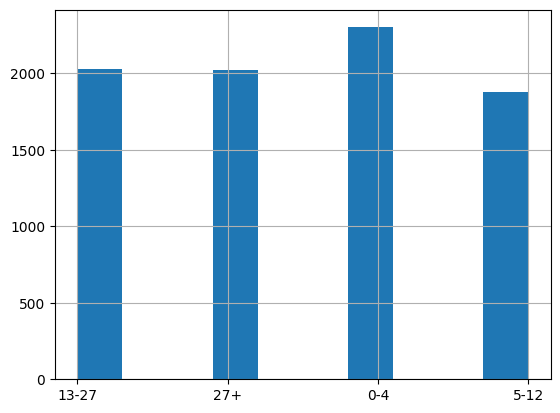

In [173]:
merged_df['batter_runs_cat'] = pd.cut(merged_df['batter_runs'], bins = [-1, 5, 13, 27, np.inf], labels = ['0-4', '5-12', '13-27', '27+'])
# pd.qcut(merged_df['batter_runs'], 4, labels = False, retbins=True)
merged_df['batter_runs_cat'].hist()

In [174]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split Train Test Data Sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state = 42);
for train_index, test_index in split.split(merged_df, merged_df['batter_runs_cat']):
    strat_train_set = merged_df.loc[train_index]
    strat_test_set = merged_df.loc[test_index]

print(strat_test_set['batter_runs_cat'].value_counts() / len(strat_test_set));

# Drop the categorical column used for strat
for set_ in (strat_test_set, strat_train_set):
    set_.drop('batter_runs_cat', axis = 1, inplace = True)


strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

batter_runs_cat
0-4      0.279465
13-27    0.246659
27+      0.245443
5-12     0.228433
Name: count, dtype: float64


## Attach the bowler type data to the dataset

In [175]:
def get_player_v_bowlers(player_name: str, match_ids, innings=[1, 2], ) -> pd.DataFrame:
    player_data = data.loc[
        (data['batter'] == player_name) & (data['innings'].isin(
            innings)) & (data['match_id'].isin(match_ids))
    ]

    player_data.head()

    # Convert all medium bowlers to fast
    player_data.loc[player_data['bowler_type'] ==
                    'Left arm Medium', 'bowler_type'] = 'Left arm Fast'
    player_data.loc[player_data['bowler_type'] ==
                    'Right arm Medium', 'bowler_type'] = 'Right arm Fast'

    player_data['out'] = (player_data['wicket_type'] != '0') & (
        player_data['wicket_type'] != 'run out')

    cols = ['batter', 'non_striker', 'runs_by_bat', 'out',
            'won', 'innings', 'over', 'delivery', 'bowler_type']
    player_data = player_data[cols]

    gp = player_data.groupby('bowler_type')

    player_v_bowler = pd.DataFrame()
    player_v_bowler['strike_rate'] = round(gp['runs_by_bat'].mean() * 100, 3)
    player_v_bowler['strike_rate_std'] = gp['runs_by_bat'].std()
    player_v_bowler['wickets'] = gp['out'].sum()
    player_v_bowler['deliveries_per_wicket'] = round(1 / gp['out'].mean(), 3)
    player_v_bowler['deliveries'] = gp.size()
    return player_v_bowler


# for player in data['batter'].unique():

#     # Attaching the player_v_bowler results to this dataset
#     print(f"Updating {player}...")
#     print(strat_train_set[strat_train_set['batter' == player]]);
#     player_scores = strat_train_set[strat_train_set['batter' == player]]

#     player_vs_bowler = get_player_v_bowlers(player_name, player_scores.index)

#     bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
#                     'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
#     for bowler_type in bowler_types:
#         if bowler_type in player_vs_bowler.index:
#             player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
#                                                                                  'strike_rate'] / 100 * player_scores[bowler_type]
#             player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
#                 player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
#             player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
#             player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
#                                                                                      'deliveries_per_wicket']
#         else:
#             player_scores[bowler_type] = 0
#             player_scores[f'{bowler_type} Expected Runs'] = 0
#             player_scores[f'{bowler_type} Expected Wickets'] = 0
#             player_scores[f'{bowler_type} Strike Rate'] = 0
#             player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0

#     # strat_train_set.update(player_scores)

match_ids_in_train_set = strat_train_set['match_id']
def attach_bowler_type_stats(player_scores):
    
    player_name = player_scores['batter'].iloc[0]
    player_vs_bowler = get_player_v_bowlers(player_name, match_ids = match_ids_in_train_set);
    
    bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox',
                    'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
    for bowler_type in bowler_types:
        if bowler_type in player_vs_bowler.index:
            player_scores[f'{bowler_type} Expected Runs'] = player_vs_bowler.loc[bowler_type,
                                                                                 'strike_rate'] / 100 * player_scores[bowler_type]
            player_scores[f'{bowler_type} Expected Wickets'] = player_scores[bowler_type] / \
                player_vs_bowler.loc[bowler_type, 'deliveries_per_wicket']
            player_scores[f'{bowler_type} Strike Rate'] = player_vs_bowler.loc[bowler_type, 'strike_rate']
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = player_vs_bowler.loc[bowler_type,
                                                                                     'deliveries_per_wicket']
        else:
            player_scores[bowler_type] = 0
            player_scores[f'{bowler_type} Expected Runs'] = 0
            player_scores[f'{bowler_type} Expected Wickets'] = 0
            player_scores[f'{bowler_type} Strike Rate'] = 0
            player_scores[f'{bowler_type} Deliveries Per Wicket'] = 0
            
    return player_scores

 # Appending bowler type data to the training set   
gp = strat_train_set.groupby('batter')
result = gp.apply(attach_bowler_type_stats);

strat_train_set = result.reset_index(drop=True)

# Appending the bowler type data to the testing set -> Only the training summaries are used (test set averages, strikerates are not used)
result = gp.apply(attach_bowler_type_stats);
strat_test_set = result.reset_index(drop=True)

# Saving checkpoint
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\978985555.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = gp.apply(attach_bowler_type_stats);
C:\Users\kaush\AppData\Local\Temp\ipykernel_50860\978985555.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = gp.apply(attach_bowler_type_stats);


In [176]:
# Additional Features Experimenting

bowler_types = ['Left arm Fast', 'Right arm Fast', 'Left arm Orthodox', 'Left arm Wrist spin', 'Right arm Legbreak', 'Right arm Offbreak']
bowler_types_expected_wickets_cols = [bowler_type + " Expected Wickets" for bowler_type in bowler_types]
bowler_types_expected_runs_cols = [bowler_type + " Expected Runs" for bowler_type in bowler_types]

strat_train_set['expected_wickets'] = strat_train_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
strat_train_set['expected_runs'] = strat_train_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
strat_train_set['expected_runs'] = strat_train_set['expected_runs'] / np.sqrt(strat_train_set['expected_wickets']) 

strat_test_set['expected_wickets'] = strat_test_set.loc[:, bowler_types_expected_wickets_cols].sum(axis=1)
strat_test_set['expected_runs'] = strat_test_set.loc[:, bowler_types_expected_runs_cols].sum(axis=1)
strat_test_set['expected_runs'] = strat_test_set['expected_runs'] / np.sqrt(strat_test_set['expected_wickets'])


print(strat_train_set.loc[:, ['batter_runs', 'expected_runs']].corr())
strat_train_set.loc[:, ['batter_runs', 'expected_runs']]

               batter_runs  expected_runs
batter_runs       1.000000       0.406255
expected_runs     0.406255       1.000000


,batter_runs,expected_runs
0,27,75.239733
1,2,50.300966
2,5,58.000050
3,28,62.951376
4,28,44.419061
...,...,...
6575,0,6.534860
6576,1,7.131630
6577,14,44.078949
6578,2,33.702106


In [177]:
# Remove the columns that cannot be known by the ongoing match state
# Example: The out or wicket type is not known during the match
strat_test_set.drop(['wicket_type', 'out', 'match_id', 'won'], axis = 1, inplace = True)
strat_train_set.drop(['wicket_type', 'out', 'match_id', 'won'], axis = 1, inplace = True)


In [178]:
# fill 0 for NaN
strat_test_set.fillna(value=0, inplace=True)
strat_train_set.fillna(value=0, inplace=True)
# Saving checkpoint
strat_train_set.to_csv("strat_train_set.csv")
strat_test_set.to_csv("strat_test_set.csv")

In [210]:
import pandas as pd
import numpy as np

strat_train_set = pd.read_csv('strat_train_set.csv');

# Possible Targets: But we'll be only concerned with the number of runs scored for now
targets = ['batter_runs', 'balls_faced', 'last_ball', 'strike_rate']


# Match State -> Only data available in a given moment of a match. This will be the input
X = strat_train_set.drop(targets, axis=1)
y = strat_train_set['batter_runs']

# Replace infinity values by a high constant value
# These occured at deliveries per wicket column
# So infinity can be thought as the batsman never getting out
# i.e 120 balls faced, hence replacing inf with 120
X.replace([np.inf], 120, inplace=True);

# Preprocess the data
X_processed = pd.get_dummies(data=X,dtype=int)

In [211]:
X_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6580 entries, 0 to 6579
Columns: 621 entries, Unnamed: 0 to batting_team_Zimbabwe
dtypes: bool(2), float64(36), int32(577), int64(6)
memory usage: 16.6 MB


In [212]:
X.drop('Unnamed: 0', inplace=True, axis=1)
X.columns

Index(['batter', 'innings', 'wickets_fallen', 'bowling_team', 'batting_team',
       'toss_winner', 'runs_remain', 'first_ball', 'current_team_total',
       'is_powerplay', 'Left arm Fast', 'Left arm Orthodox',
       'Left arm Wrist spin', 'Right arm Fast', 'Right arm Legbreak',
       'Right arm Offbreak', 'recent_form', 'venue_mean_total',
       'venue_first_bat_won_ratio', 'is_host', 'Left arm Fast Expected Runs',
       'Left arm Fast Expected Wickets', 'Left arm Fast Strike Rate',
       'Left arm Fast Deliveries Per Wicket', 'Right arm Fast Expected Runs',
       'Right arm Fast Expected Wickets', 'Right arm Fast Strike Rate',
       'Right arm Fast Deliveries Per Wicket',
       'Left arm Orthodox Expected Runs', 'Left arm Orthodox Expected Wickets',
       'Left arm Orthodox Strike Rate',
       'Left arm Orthodox Deliveries Per Wicket',
       'Left arm Wrist spin Expected Runs',
       'Left arm Wrist spin Expected Wickets',
       'Left arm Wrist spin Strike Rate',
      

In [213]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

# Cross Validation (Train Set)
Baseline model without any hyperparameter tuning or complex feature engineering

In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

forest_reg = RandomForestRegressor(random_state=42, criterion='absolute_error')
scores = cross_val_score(forest_reg, X_processed, y, scoring="neg_mean_absolute_error", cv = 10)


display_scores(scores)

Scores:  [ -9.90409574 -11.26101824 -11.57342705 -10.30946049 -11.39929331
 -10.89800912 -10.38901216 -10.8731459  -11.54961246 -11.63888298]
Mean:  -10.979595744680852
Standard Deviation:  0.5779374913692757


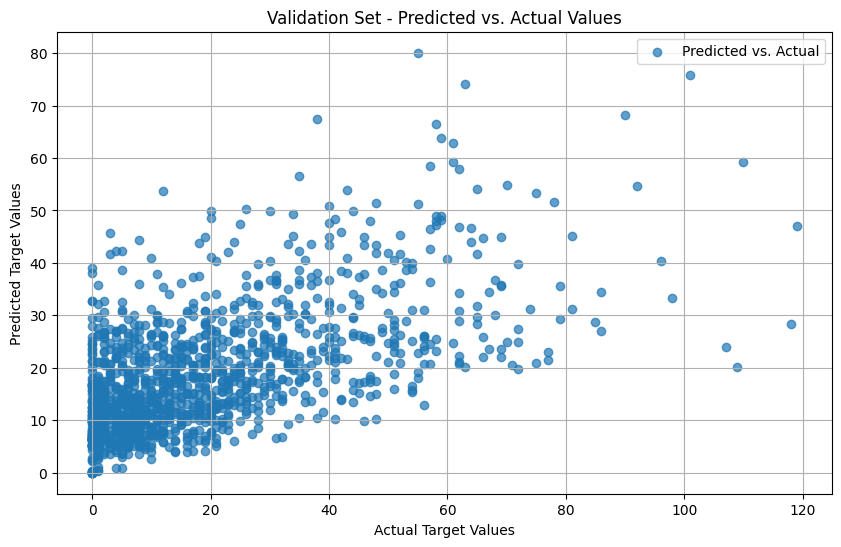

In [96]:
import matplotlib.pyplot as plt

forest_reg.fit(X_train, y_train)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, forest_reg.predict(X_val), alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

The random forest regressor gives a good result compared to the earlier models tested. \
The mean rmse is 8.33, which means that if the model predicts that the batsman will score 20, the average error will be in 8 runs width so it can be either 28 or 12

# Stratified K Fold Validation Set

### GradientBoosting Model

In [217]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor


# Split data into training and validating sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=200, random_state=42, loss= 'absolute_error')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.2f}")

Root Mean Squared Error (RMSE): 15.06
Mean Absolute Error (MAE): 10.39


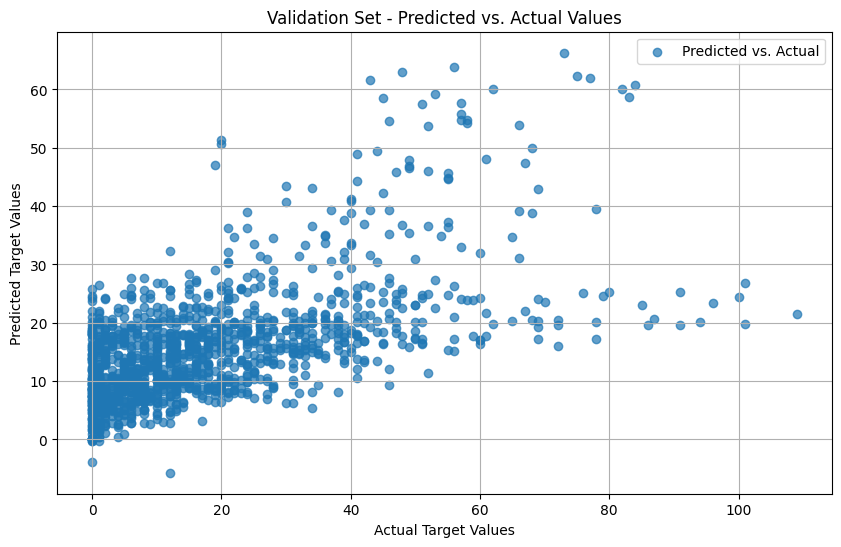

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

### XGBoost

In [189]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=42, n_estimators=1000, loss='reg:pseudohubererror')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the val set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.2f}")

c:\Users\kaush\pyver\py3115\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)


Root Mean Squared Error (RMSE): 16.70
Mean Absolute Error (MAE): 12.04


# Random Forest Regressor

In [122]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_estimators=100, criterion='absolute_error')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_val)

# Evaluate model performance
from sklearn.metrics import mean_absolute_error
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_val, y_pred):.2f}")

Mean Absolute Error (MAE): 11.37


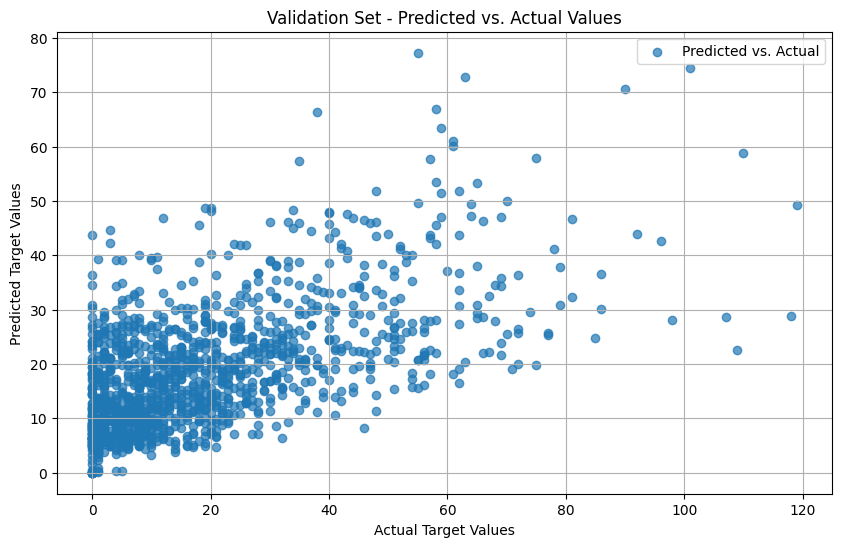

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [125]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                          Feature  Gini Importance
42                  expected_runs         0.118201
4                     runs_remain         0.094722
5                      first_ball         0.045588
41               expected_wickets         0.037899
21   Right arm Fast Expected Runs         0.030325
..                            ...              ...
205                batter_GB Hogg         0.000000
369            batter_MS Sinclair         0.000000
218              batter_GJ Snyman         0.000000
219            batter_GJ Thompson         0.000000
69             batter_AM Blignaut         0.000000

[627 rows x 2 columns]


### Deep NN

In [201]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

scaler = StandardScaler()
X_processed_scaled = scaler.fit_transform(X_processed)
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Define the model architecture
model = keras.Sequential([
  layers.Dense(1024, activation='leaky_relu', input_shape=(X_train.shape[1],)),  # First hidden layer with 256 neurons and ReLU activation
  layers.Dense(512, activation='leaky_relu'),  # First hidden layer with 256 neurons and ReLU activation
  layers.Dense(256, activation='leaky_relu'),  # Second hidden layer with 128 neurons and ReLU activation
  layers.Dense(64, activation='leaky_relu'),  # Third hidden layer with 64 neurons and ReLU activation
  layers.Dense(32, activation='leaky_relu'),  # Third hidden layer with 64 neurons and ReLU activation
  layers.Dense(1)  # Output layer with 1 neuron for regression (single value prediction)
])

# Compile the model
model.compile(loss='mae', optimizer='adam')  # Mean absolute error loss and Adam optimizer

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Train the model with validation split
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])  # Added validation data

# Access training and validation loss history for further analysis (optional)
train_loss = history.history['loss']
val_loss = history.history['val_loss']


Epoch 1/100


c:\Users\kaush\pyver\py3115\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 36.2333 - val_loss: 12.4227
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 13.5988 - val_loss: 13.7522
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 12.6363 - val_loss: 11.9574
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 12.3880 - val_loss: 12.1265
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 11.9811 - val_loss: 11.4719
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 11.6099 - val_loss: 11.2397
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 11.6837 - val_loss: 12.0133
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 11.8348 - val_loss: 12.4290
Epoch 9/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 11.6243 - val_loss: 11.0864
Epoch 10/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 11.3385 - val_loss: 10.9692
Epoch 11/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 11.6131 - val_loss: 12.3035
Epoch 12/100
165/165

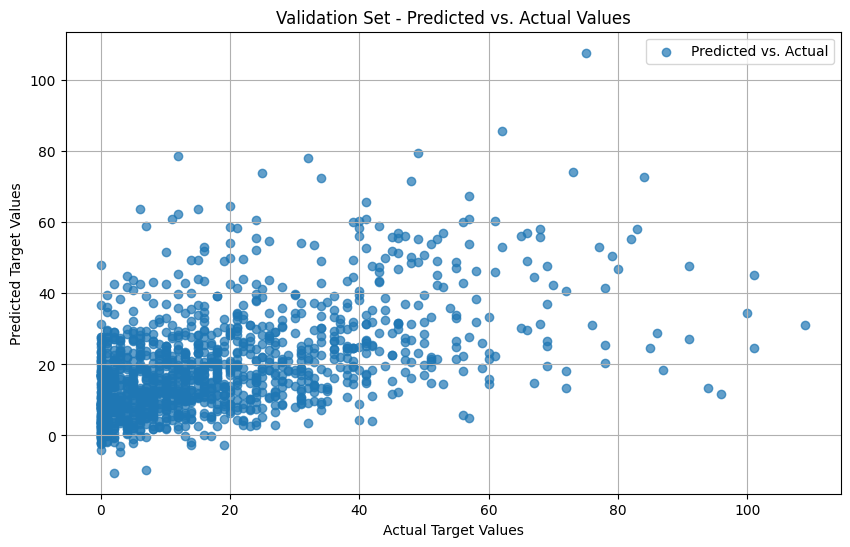

In [202]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.7, label='Predicted vs. Actual')
plt.xlabel('Actual Target Values')
plt.ylabel('Predicted Target Values')
plt.title('Validation Set - Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()